# Air pollution GRU and LSTM model

In [1]:
import os
import pandas as pd
import numpy as np
import random
# PyTorch
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from torchmetrics.functional.regression import symmetric_mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
# Ray
import ray
from ray import tune
from ray.train.torch import enable_reproducibility
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.pytorch_lightning import TuneReportCheckpointCallback
# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Visualization
import seaborn as sn
sn.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import datetime
import plotly.figure_factory as ff

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Plot the loss curve based on the latest file from lightning logs
def plot_loss_curve():
    latest_file = os.path.join(max([os.path.join("/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/lightning_logs", f) 
                                    for f in os.listdir("lightning_logs")], 
                                    key=os.path.getctime), "metrics.csv")
    loss_data = pd.read_csv(latest_file)
    loss_data['val_loss'] = loss_data.val_loss.shift(1)
    loss_data = loss_data[["epoch", "train_loss", "val_loss"]].dropna()
    loss_data['epoch'] = loss_data.epoch

    plt.plot(loss_data['epoch'], loss_data['train_loss'], label="Training loss")
    plt.plot(loss_data['epoch'], loss_data['val_loss'], label = "Validation loss")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss metric")
    plt.xticks(loss_data['epoch'])
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

## Exploring the dataset

In [32]:
pollution_df  = pd.read_csv("data/LSTM-Multivariate_pollution.csv")

In [ ]:
pollution_df.head()

In [ ]:
pollution_df.shape

In [ ]:
pollution_df.dtypes

In [ ]:
pollution_df.describe()

In [ ]:
pollution_df.describe().applymap("{0:.4f}".format)

In [ ]:
fig =  ff.create_table(pollution_df.describe().applymap("{0:.4f}".format), index=True)
fig.update_layout(
    autosize=False,
    width=1000,
    height=400
)
fig.write_image("visualizations/pandas_describe.png", scale=2)
fig.show()

In [ ]:
pollution_df.groupby("wnd_dir").wnd_dir.count()

In [ ]:
pollution_df.isna().sum()

## Visualization

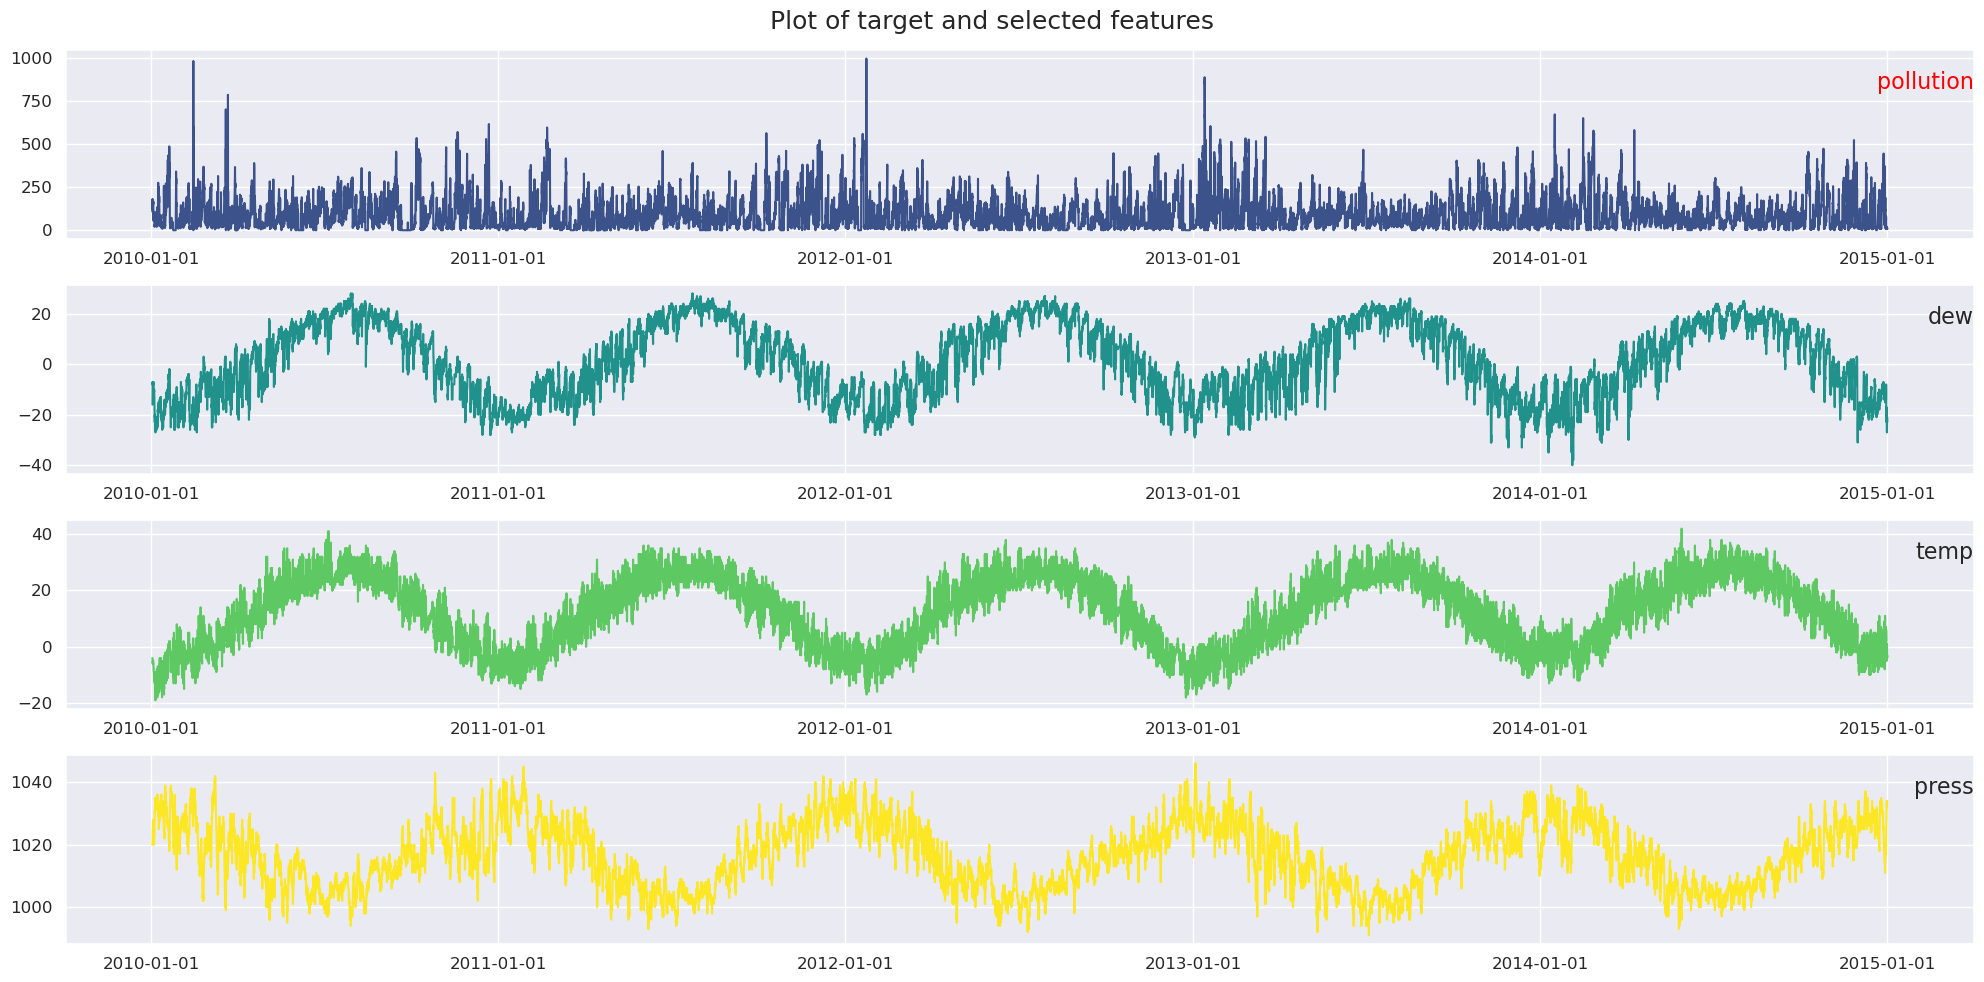

In [33]:
# Visualizing the numerical values
values = pollution_df.values
dates = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') for date_str in values[:,0]]

groups = [1, 2, 3, 4]
i = 1

fig, axs = plt.subplots(len(groups), 1, figsize=(20, 10), facecolor='white')
for group, ax in zip(groups, axs):
    ax.plot(dates, values[:, group], color=cm.viridis(group/len(groups)))
    if pollution_df.columns[group] == "pollution":
        ax.set_title(pollution_df.columns[group], y=0.75, loc='right', fontsize=16, color="red")
    else:
        ax.set_title(pollution_df.columns[group], y=0.75, loc='right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    i += 1

plt.suptitle('Plot of target and selected features', fontsize=18)
plt.tight_layout()
plt.show()

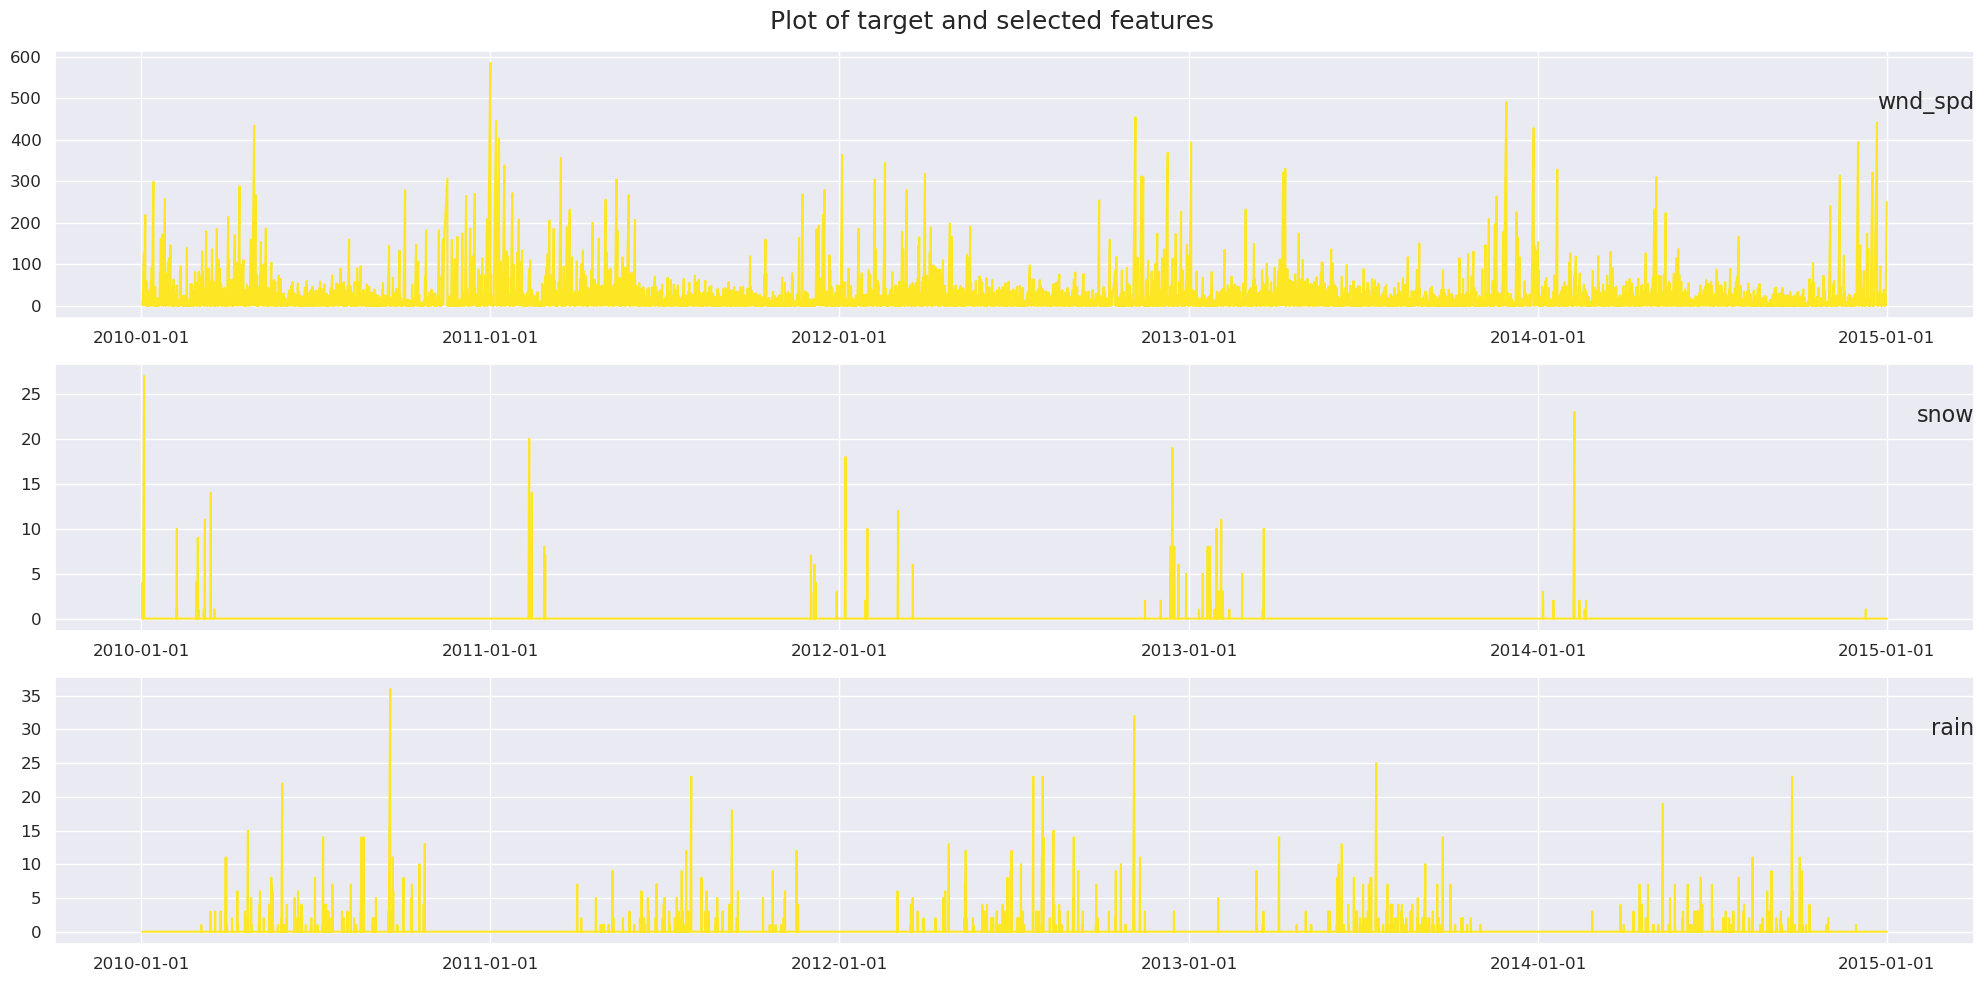

In [34]:
# Visualizing the numerical values
values = pollution_df.values
dates = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') for date_str in values[:,0]]

groups = [6, 7, 8]
i = 1

fig, axs = plt.subplots(len(groups), 1, figsize=(20, 10), facecolor='white')
for group, ax in zip(groups, axs):
    ax.plot(dates, values[:, group], color=cm.viridis(group/len(groups)))
    if pollution_df.columns[group] == "pollution":
        ax.set_title(pollution_df.columns[group], y=0.75, loc='right', fontsize=16, color="red")
    else:
        ax.set_title(pollution_df.columns[group], y=0.75, loc='right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    i += 1

plt.suptitle('Plot of target and selected features', fontsize=18)
plt.tight_layout()
plt.show()

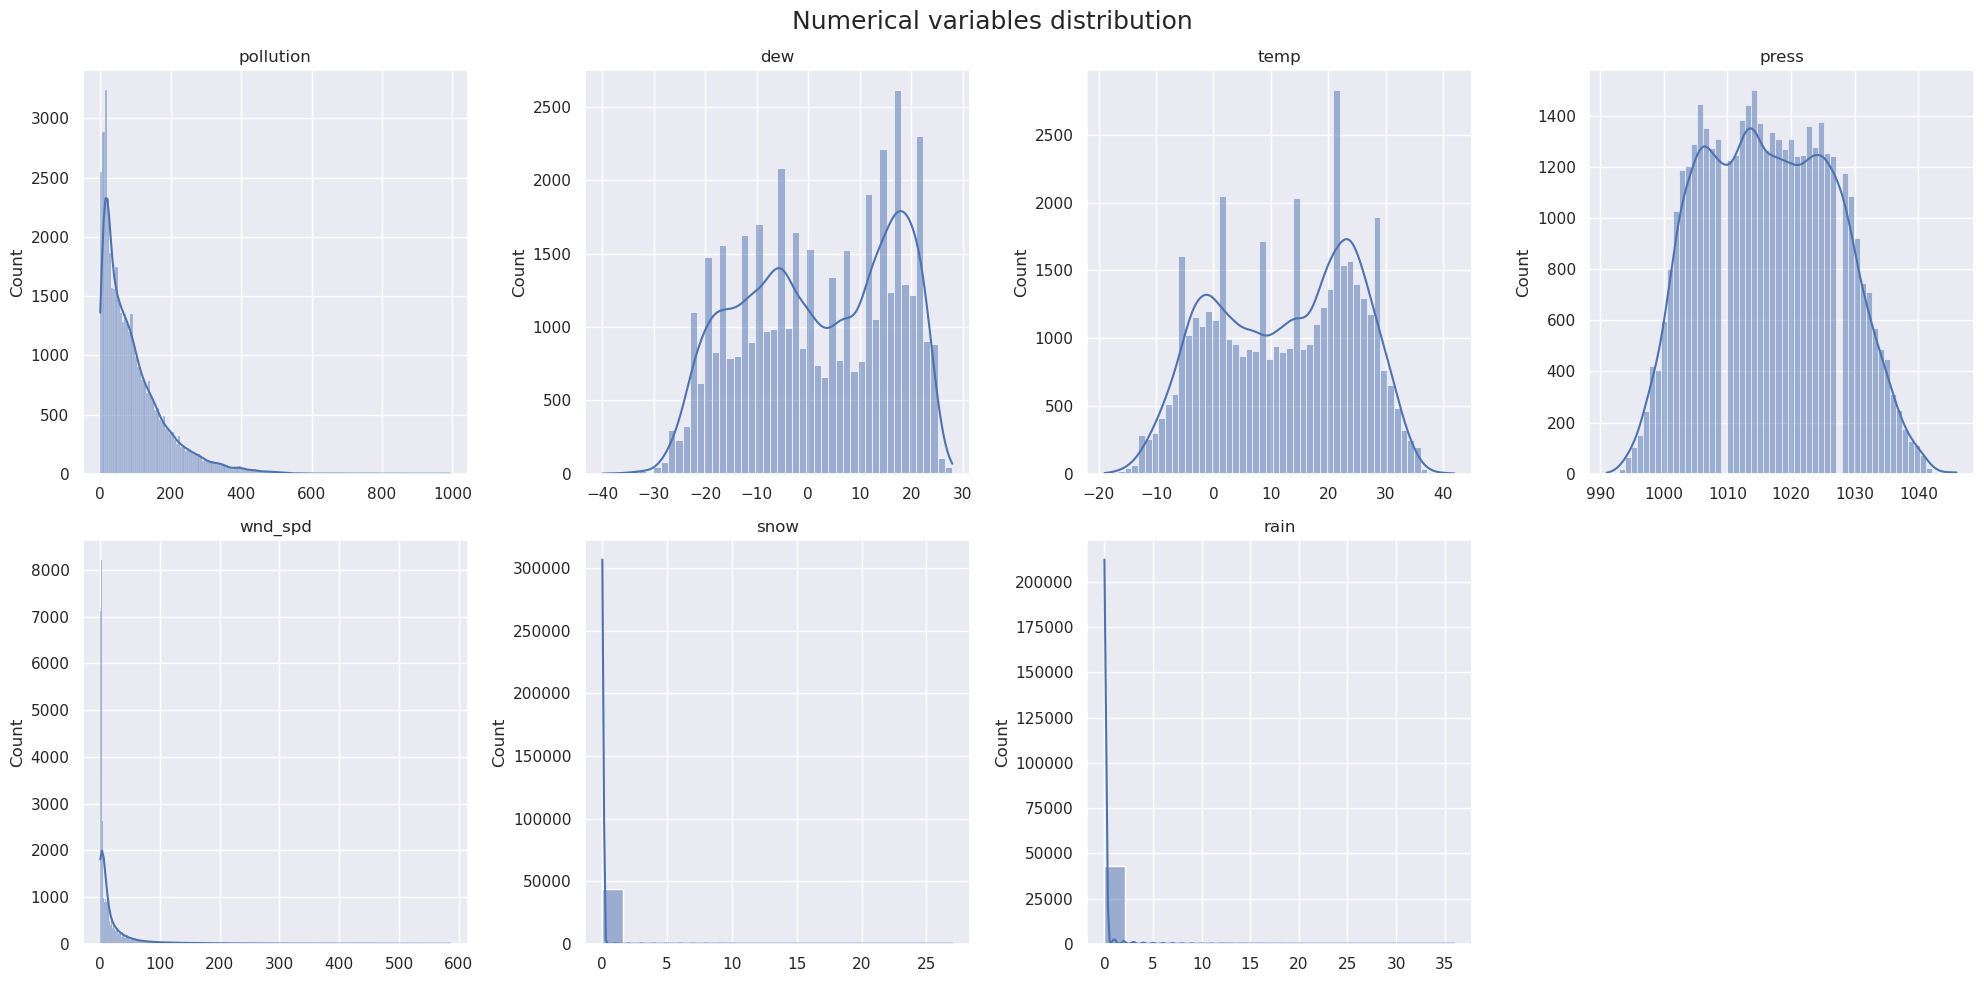

In [35]:
groups = [1, 2, 3, 4, 6, 7, 8]

# Create separate subplots for each boxplot
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(len(groups)):
    sn.histplot(pollution_df.values[:, groups[i]], ax=axes[i], kde=True)
    axes[i].set_title(pollution_df.columns[groups[i]])

plt.delaxes(axes[7])
plt.suptitle('Numerical variables distribution', fontsize=18)
plt.tight_layout()
plt.show()

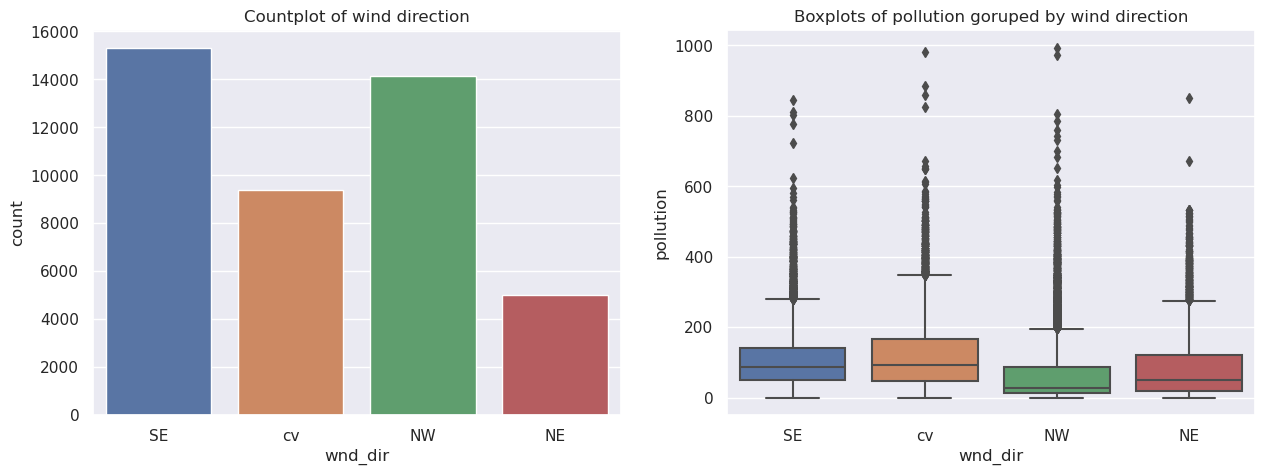

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sn.countplot(x=pollution_df["wnd_dir"], ax=axes[0])
axes[0].set_title("Countplot of wind direction")
sn.boxplot(data=pollution_df, x="wnd_dir", y="pollution", ax=axes[1])
axes[1].set_title("Boxplots of pollution goruped by wind direction")
plt.show()

## Pytorch codes

### Custom dataset class

In [3]:
# Custom dataset class for pollution data
class PollutionData(Dataset):
    def __init__(self, X, y, seq_len, device=device):
        # Features and targets
        self.X = X
        self.y = y
        # Length of sequence
        self.seq_len = seq_len
        # Chosen device
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]).to(torch.float32).to(self.device), torch.tensor(self.y[idx]).to(torch.float32).to(self.device)

### Lightning dataloader

In [4]:
# Custom lightning dataloader
class PollutionDataLoader(pl.LightningDataModule):
    def __init__(self, train_dir, seq_len, X_scaler, y_scaler, test_size, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_dir = train_dir
        self.seq_len = seq_len
        self.X_scaler = X_scaler
        self.y_scaler = y_scaler
        self.test_size = test_size
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.train_df = None
        self.test_df = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.pollution_train = None
        self.pollution_val = None
        self.pollution_test = None

    def setup(self, stage):
        # Load the dataset
        self.train_df = pd.read_csv(self.train_dir)
        # Map the categories of wind direction to numeric values
        mapping = {"NE": 0, "NW": 1, "SE": 2, "cv": 3}
        self.train_df["wnd_dir"] = self.train_df.wnd_dir.map(mapping)
        # Create X and y by dropping date
        X = self.train_df.drop(["date"], axis=1)
        # Shift features by 24, because we want to predict pollution for the next 24h
        X = X.shift(periods=24, fill_value=0).values
        y = self.train_df[["pollution"]].values
        # Creating new X and y sets, containing sequences of lagged features
        new_X, new_y = list(), list()
        for idx in range(len(X)):
            # If index is lower than sequence length, apply padding
            if idx + 1 >= self.seq_len:
                X_sample = X[(idx + 1 - self.seq_len):idx + 1]
            else:
                X_sample = X[:idx + 1]
                padding = np.zeros((self.seq_len - idx - 1, X_sample.shape[1]))
                X_sample = np.concatenate([padding, X_sample], axis = 0)

            if idx + 1 >= 24:
                y_sample = y[(idx + 1 - 24):idx + 1]
            else:
                y_sample = y[:idx + 1]
                padding = np.zeros((24 - idx - 1, y_sample.shape[1]))
                y_sample = np.concatenate([padding, y_sample], axis = 0)
            new_X.append(X_sample), new_y.append(y_sample)
        new_X, new_y = np.array(new_X), np.array(new_y)
        # Test set will consist of the last available month
        new_X_train, new_y_train = new_X[:-720], new_y[:-720]
        self.X_test, self.y_test = new_X[-720:], new_y[-720:]
        # Splitting the dataset into training and validation sets
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(new_X_train
                                                                              , new_y_train
                                                                              , test_size=self.test_size
                                                                              , shuffle=False
                                                                              , random_state=self.random_sate
                                                                              )
        # If scalers are provided, they're applied on the data
        # Scalers cannot be applied on the current shape of the data, so observations are flattened first
        if self.X_scaler and self.y_scaler:
            num_instances, num_time_steps, num_features = self.X_train.shape
            self.X_train = self.X_scaler.fit_transform(np.reshape(self.X_train, (-1, num_features)))
            self.X_train = np.reshape(self.X_train, (num_instances, num_time_steps, num_features))
            self.y_train = self.y_scaler.fit_transform(np.reshape(self.y_train, (-1, 1)))
            self.y_train = np.reshape(self.y_train, (num_instances, 24, 1))
            self.X_val, self.y_val = self.normalize(self.X_val, self.y_val)
            self.X_test, self.y_test = self.normalize(self.X_test, self.y_test)

        # Create three instances of the custom dataset class
        self.pollution_train = PollutionData(self.X_train
                                             , self.y_train
                                             , seq_len=self.seq_len
                                             , device=self.device
                                             )
        self.pollution_val = PollutionData(self.X_val
                                           , self.y_val
                                           , seq_len=self.seq_len
                                           , device=self.device
                                             )
        self.pollution_test = PollutionData(self.X_test
                                            , self.y_test
                                            , seq_len=self.seq_len
                                            , device=self.device
                                            )

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.pollution_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.pollution_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def test_dataloader(self):
        # Return the dataloader of test data
        return DataLoader(self.pollution_test
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )
    # Method for applying normalization after training the scaler
    # Reduces boilerplate code
    def normalize(self, normal_X, normal_y):
        num_instances, num_time_steps, num_features = normal_X.shape
        normal_X = self.X_scaler.transform(np.reshape(normal_X, (-1, num_features)))
        normal_X = np.reshape(normal_X, (num_instances, num_time_steps, num_features))
        normal_y = self.y_scaler.transform(np.reshape(normal_y, (-1, 1)))
        normal_y = np.reshape(normal_y, (num_instances, 24, 1))

        return normal_X, normal_y

### LSTM model class

In [5]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f, dropout_rate, activ):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.dropout_rate = dropout_rate
        self.activ = activ()
        self.lstm = nn.LSTM(input_size=self.input_size
                            , hidden_size=self.hidden_size
                            , num_layers=self.num_layers
                            , batch_first=True
                            , dropout=self.dropout_rate
                            )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features)
    
    def forward(self, X):
        X, _ = self.lstm(X)
        X = self.activ(X[:,-1,:])
        X = self.linear1(X)

        return X.unsqueeze(2)

### GRU model class

In [6]:
# GRU model class
class GRUModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f, dropout_rate, activ):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.dropout_rate = dropout_rate
        self.activ = activ()
        self.gru = nn.GRU(input_size=self.input_size
                          , hidden_size=self.hidden_size
                          , num_layers=self.num_layers
                          , batch_first=True
                          , dropout=self.dropout_rate
                          )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features
                                 )
    
    def forward(self, X):
        X, _ = self.gru(X)
        X = self.activ(X[:,-1,:])
        X = self.linear1(X)

        return X.unsqueeze(2)

### PyTorch Lightning time-series model class

In [7]:
# Time-series model created with lightning
class TSModel(pl.LightningModule):
    def __init__(self, model, lr=0.01):
        super().__init__()
        # Model of choice (either LSTM or GRU)
        self.model = model
        # Learning rate
        self.lr = lr

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        train_loss = F.mse_loss(y_pred, y)
        self.log("train_loss", train_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        val_loss = F.mse_loss(y_pred, y)
        self.log("val_loss", val_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        mse_test_loss = F.mse_loss(y_pred, y)
        mae_test_loss = F.l1_loss(y_pred, y)
        mape_test_loss = symmetric_mean_absolute_percentage_error(y_pred, y)
        self.log_dict({"MSE_test_loss": mse_test_loss, "MAE_test_loss": mae_test_loss, "SMAPE_test_loss": mape_test_loss}, sync_dist=True)
    
    def predict_step(self, batch, batch_id):
        X, y = batch
        y_pred = self.model(X)

        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Ray tuner

In [8]:
ray_epochs = 20

config = {
    "seq_len": tune.grid_search([48])
    , "h_size": tune.grid_search([8, 16, 32])
    , "num_l": tune.grid_search([2, 4, 8])
    , "dropout_rate": tune.grid_search([0.2, 0.4])
    , "activ": tune.grid_search([nn.Identity, nn.ReLU])
    , "lr": tune.grid_search([1e-3, 1e-2])
    , "batch_size": tune.grid_search([128, 256])
}

scheduler_asha = ASHAScheduler(
    max_t=20,
    grace_period=2,
    reduction_factor=2,
)

tune_report_callback = TuneReportCheckpointCallback(
    metrics={
    "val_loss": "val_loss"
    },
    filename="ray_ckpt",
    on="validation_end",
)

In [9]:
# Function for training model with Ray tuner
def model_train_func(config, max_epochs, model_type):
    enable_reproducibility(seed=42)
    
    dm = PollutionDataLoader(train_dir="/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/data/LSTM-Multivariate_pollution.csv"
                             , seq_len=config["seq_len"]
                             , X_scaler=MinMaxScaler()
                             , y_scaler=MinMaxScaler()
                             , test_size=0.3
                             , random_state=42
                             , batch_size=config["batch_size"]
                             , num_workers=0
                             , device=device
                             )
    
    if model_type == "LSTM":
        torch_model = LSTMModel(in_size=8
                                , h_size=config["h_size"]
                                , num_l=config["num_l"]
                                , out_f=24
                                , dropout_rate=config['dropout_rate']
                                , activ=config["activ"]).to(device)
    else:
        torch_model = GRUModel(in_size=8
                               , h_size=config["h_size"]
                               , num_l=config["num_l"]
                               , out_f=24
                               , dropout_rate=config['dropout_rate']
                               , activ=config["activ"]).to(device)
            
    model = TSModel(torch_model, lr=config['lr'])

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=False,
        callbacks=[
            tune_report_callback,
        ],
    )

    trainer.fit(model, datamodule=dm)

#### LSTM

In [10]:
# LSTM hyperparameter tuning
pl.seed_everything(42, workers=True)

lstm_search_results = tune.run(
    tune.with_parameters(
        model_train_func
        , max_epochs=ray_epochs
        , model_type="LSTM"
        )
        , name="lstm_trials20"
        , metric="val_loss"
        , mode="min"
        , config=config
        , num_samples=1
        , scheduler=scheduler_asha
        , max_failures=3
        , max_concurrent_trials=1
        , resources_per_trial={"cpu": 1, "gpu": 0}
        # , resume="LOCAL+ERRORED"
)

Seed set to 42
2023-12-09 21:50:36,797	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-12-09 21:50:41,856	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-12-09 21:50:41,859	INFO tune.py:586 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-12-09 21:50:41,971	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-12-09 21:50:41,972	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(model_train_func pid=224028) GPU available: False, used: False
(model_train_func pid=224028) TPU available: False, using: 0 TPU cores
(model_train_func pid=224028) IPU available: False, using: 0 IPUs
(model_train_func pid=224028) HPU available: False, using: 0 HPUs
(model_train_func pid=224028) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
(model_train_func pid=224028) Missing logger folder: /home/maciej/ray_results/lstm_trials20/model_train_func_9dcc1_00000_0_activ=ref_ph_d087e18c,batch

Trial name,should_checkpoint,val_loss
model_train_func_9dcc1_00000,True,0.00463461
model_train_func_9dcc1_00001,True,0.00650858
model_train_func_9dcc1_00002,True,0.00780376
model_train_func_9dcc1_00003,True,0.0102219
model_train_func_9dcc1_00004,True,0.00733216
model_train_func_9dcc1_00005,True,0.00551582
model_train_func_9dcc1_00006,True,0.00787834
model_train_func_9dcc1_00007,True,0.00792003
model_train_func_9dcc1_00008,True,0.00455479
model_train_func_9dcc1_00009,True,0.0045343


(model_train_func pid=224028) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/lstm_trials20/model_train_func_9dcc1_00000_0_activ=ref_ph_d087e18c,batch_size=128,dropout_rate=0.2000,h_size=8,lr=0.0010,num_l=2,seq_len=48_2023-12-09_21-50-42/checkpoint_000001)
(model_train_func pid=224028) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/lstm_trials20/model_train_func_9dcc1_00000_0_activ=ref_ph_d087e18c,batch_size=128,dropout_rate=0.2000,h_size=8,lr=0.0010,num_l=2,seq_len=48_2023-12-09_21-50-42/checkpoint_000002)
(model_train_func pid=224028) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/lstm_trials20/model_train_func_9dcc1_00000_0_activ=ref_ph_d087e18c,batch_size=128,dropout_rate=0.2000,h_size=8,lr=0.0010,num_l=2,seq_len=48_2023-12-09_21-50-42/checkpoint_000003)
(model_train_func pid=224028) Checkpoint successfully created at: Checkpoint(filesystem=

In [11]:
lstm_search_results.best_config

{'seq_len': 48,
 'h_size': 32,
 'num_l': 2,
 'dropout_rate': 0.4,
 'activ': torch.nn.modules.activation.ReLU,
 'lr': 0.001,
 'batch_size': 128}

In [12]:
lstm_search_results.results_df.to_csv("lstm_results_df.csv")

#### GRU

In [10]:
# GRU hyperparameter tuning
pl.seed_everything(42, workers=True)

gru_search_results = tune.run(
    tune.with_parameters(
        model_train_func
        , max_epochs=ray_epochs
        , model_type="GRU"
        )
        , name = "gru_trials20"
        , metric="val_loss"
        , mode="min"
        , config=config
        , num_samples=1
        , scheduler=scheduler_asha
        , max_failures=3
        , max_concurrent_trials=1
        , resources_per_trial={"cpu": 1, "gpu": 0}
        # , resume="LOCAL+ERRORED"
)

Seed set to 42
2023-12-10 00:56:24,831	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-12-10 00:56:28,837	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-12-10 00:56:28,841	INFO tune.py:586 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-12-10 00:56:28,880	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-12-10 00:56:28,881	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(model_train_func pid=287499) GPU available: False, used: False
(model_train_func pid=287499) TPU available: False, using: 0 TPU cores
(model_train_func pid=287499) IPU available: False, using: 0 IPUs
(model_train_func pid=287499) HPU available: False, using: 0 HPUs
(model_train_func pid=287499) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
(model_train_func pid=287499) Missing logger folder: /home/maciej/ray_results/gru_trials20/model_train_func_91df8_00000_0_activ=ref_ph_d087e18c,batch_

Trial name,should_checkpoint,val_loss
model_train_func_91df8_00000,True,0.0046513
model_train_func_91df8_00001,True,0.00772077
model_train_func_91df8_00002,True,0.00767308
model_train_func_91df8_00003,True,0.00929336
model_train_func_91df8_00004,True,0.00484046
model_train_func_91df8_00005,True,0.00778498
model_train_func_91df8_00006,True,0.00770456
model_train_func_91df8_00007,True,0.00930053
model_train_func_91df8_00008,True,0.00445024
model_train_func_91df8_00009,True,0.00462566


(model_train_func pid=287499) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/gru_trials20/model_train_func_91df8_00000_0_activ=ref_ph_d087e18c,batch_size=128,dropout_rate=0.2000,h_size=8,lr=0.0010,num_l=2,seq_len=48_2023-12-10_00-56-28/checkpoint_000000)
(model_train_func pid=287499) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/gru_trials20/model_train_func_91df8_00000_0_activ=ref_ph_d087e18c,batch_size=128,dropout_rate=0.2000,h_size=8,lr=0.0010,num_l=2,seq_len=48_2023-12-10_00-56-28/checkpoint_000001)
(model_train_func pid=287499) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/gru_trials20/model_train_func_91df8_00000_0_activ=ref_ph_d087e18c,batch_size=128,dropout_rate=0.2000,h_size=8,lr=0.0010,num_l=2,seq_len=48_2023-12-10_00-56-28/checkpoint_000002)
(model_train_func pid=287499) Checkpoint successfully created at: Checkpoint(filesystem=loc

In [11]:
gru_search_results.best_config

{'seq_len': 48,
 'h_size': 32,
 'num_l': 2,
 'dropout_rate': 0.2,
 'activ': torch.nn.modules.linear.Identity,
 'lr': 0.001,
 'batch_size': 256}

In [12]:
gru_search_results.results_df.to_csv("gru_results_df.csv")

### Training loop

In [8]:
# LSTM loader with batch size=128
lstm_loader = PollutionDataLoader(train_dir="data/LSTM-Multivariate_pollution.csv"
                                  , seq_len=48
                                  , X_scaler=MinMaxScaler()
                                  , y_scaler=MinMaxScaler()
                                  , test_size=0.3
                                  , random_state=42
                                  , batch_size=256
                                  , num_workers=7
                                  , device=device
                                  )

# GRU loader with batch size=256
gru_loader = PollutionDataLoader(train_dir="data/LSTM-Multivariate_pollution.csv"
                                 , seq_len=48
                                 , X_scaler=MinMaxScaler()
                                 , y_scaler=MinMaxScaler()
                                 , test_size=0.3
                                 , random_state=42
                                 , batch_size=256
                                 , num_workers=7
                                 , device=device
                                 )

#### LSTM

In [14]:
lstm_results_df = pd.read_csv("lstm_results_df.csv")
lstm_results_df.loc[lstm_results_df["training_iteration"] == 20].nsmallest(5, "val_loss").iloc[:,[1] + list(range(-7, 0))]

,val_loss,config/seq_len,config/h_size,config/num_l,config/dropout_rate,config/activ,config/lr,config/batch_size
21,0.004387,48,32,2,0.4,<class 'torch.nn.modules.activation.ReLU'>,0.001,128
17,0.004395,48,32,2,0.2,<class 'torch.nn.modules.activation.ReLU'>,0.001,128
27,0.004421,48,8,2,0.2,<class 'torch.nn.modules.activation.ReLU'>,0.010,256
20,0.004461,48,32,2,0.4,<class 'torch.nn.modules.linear.Identity'>,0.001,128
34,0.004474,48,16,2,0.2,<class 'torch.nn.modules.linear.Identity'>,0.010,256


In [9]:
pl.seed_everything(42, workers=True)
lstm_model = LSTMModel(in_size=8, h_size=16, num_l=2, out_f=24, dropout_rate=0.4, activ=nn.Identity).to(device)
lstm_ts_model = TSModel(lstm_model, lr=0.001)
lstm_trainer = pl.Trainer(max_epochs=50
                          , callbacks=[# EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00, patience=4, verbose=False), 
                                       ModelCheckpoint(monitor="val_loss", save_top_k=-1)]
                          , check_val_every_n_epoch=1
                          )

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [10]:
%%time
lstm_trainer.fit(lstm_ts_model, datamodule=lstm_loader)


  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 4.2 K 
------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 14min 22s, sys: 52.3 s, total: 15min 15s
Wall time: 4min 44s


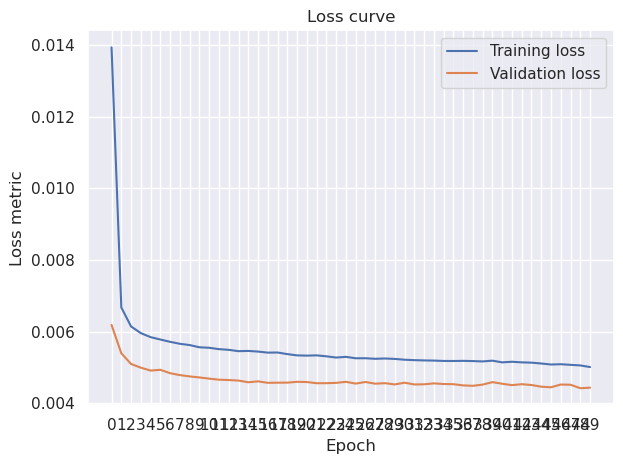

In [3]:
plot_loss_curve()

#### GRU

In [14]:
gru_results_df = pd.read_csv("gru_results_df.csv")
gru_results_df.loc[gru_results_df["training_iteration"] == 20].nsmallest(5, "val_loss").iloc[:,[1] + list(range(-7, 0))]

,val_loss,config/seq_len,config/h_size,config/num_l,config/dropout_rate,config/activ,config/lr,config/batch_size
18,0.004366,48,32,2,0.2,<class 'torch.nn.modules.linear.Identity'>,0.001,256
21,0.004390,48,32,2,0.4,<class 'torch.nn.modules.activation.ReLU'>,0.001,128
22,0.004414,48,32,2,0.4,<class 'torch.nn.modules.linear.Identity'>,0.001,256
8,0.004450,48,16,2,0.2,<class 'torch.nn.modules.linear.Identity'>,0.001,128
19,0.004494,48,32,2,0.2,<class 'torch.nn.modules.activation.ReLU'>,0.001,256


In [45]:
pl.seed_everything(42, workers=True)
gru_model = GRUModel(in_size=8, h_size=16, num_l=2, out_f=24, dropout_rate=0.2, activ=nn.Identity).to(device)
gru_ts_model = TSModel(gru_model, lr=0.01)
# Runnign the model for 20 epochs
gru_trainer = pl.Trainer(max_epochs=20, enable_checkpointing=True
                         , callbacks=[# EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00, patience=5, verbose=False), 
                                      ModelCheckpoint(monitor="val_loss", save_top_k=-1)]
                         , check_val_every_n_epoch=1
                         )

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [46]:
%%time
gru_trainer.fit(gru_ts_model, datamodule=gru_loader)


  | Name  | Type     | Params
-----------------------------------
0 | model | GRUModel | 3.3 K 
-----------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


CPU times: user 16min 45s, sys: 46.8 s, total: 17min 32s
Wall time: 5min 7s


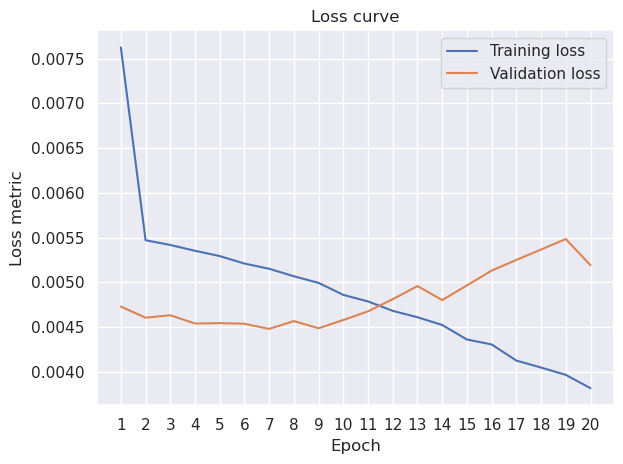

In [47]:
plot_loss_curve()

#### Picking the best model checkpoints

In [4]:
best_lstm = TSModel.load_from_checkpoint(checkpoint_path="lightning_logs/version_0/checkpoints/epoch=49-step=5900.ckpt", model=lstm_model, lr=0.001)
best_gru = TSModel.load_from_checkpoint(checkpoint_path="lightning_logs/version_2/checkpoints/epoch=8-step=1062.ckpt", model=gru_model, lr=0.01)

NameError: name 'TSModel' is not defined

#### Prediction

In [49]:
lstm_loader.setup('test')
gru_loader.setup('test')

In [50]:
def get_predictions(model, trainer, loader):
    preds = trainer.predict(model, dataloaders=loader.test_dataloader())
    preds = loader.y_scaler.inverse_transform(torch.cat(preds).squeeze(2))

    return preds

In [51]:
pollution_df = pd.read_csv("data/LSTM-Multivariate_pollution.csv")
test_set = pollution_df.iloc[-744:]
values = test_set.values

dates = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') for date_str in values[:,0]]
date_checks = random.choices(range(len(dates)-24), k=4)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

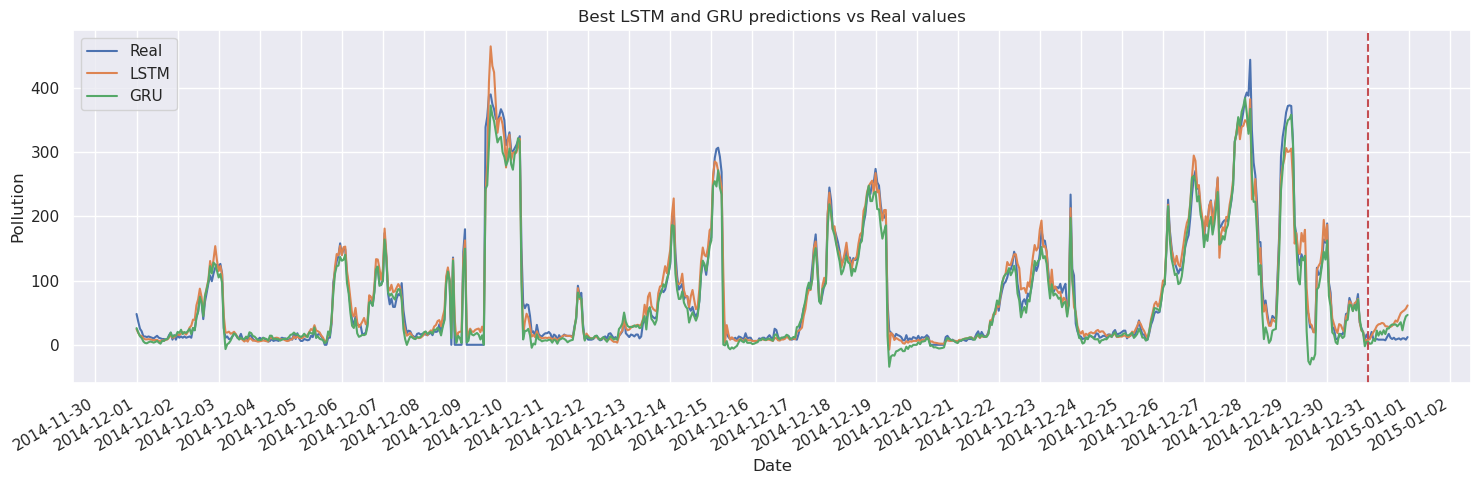

In [52]:
lstm_preds = [i[0] for i in get_predictions(best_lstm, lstm_trainer, lstm_loader)] + list(get_predictions(best_lstm, lstm_trainer, lstm_loader)[-1])
gru_preds = [i[0] for i in get_predictions(best_gru, gru_trainer, gru_loader)] + list(get_predictions(best_gru, gru_trainer, gru_loader)[-1])
plt.figure(figsize=(15,5))
plt.ylabel("Pollution")
plt.xlabel("Date")
plt.plot(dates, test_set["pollution"], label="Real")
plt.plot(dates, lstm_preds, label="LSTM")
plt.plot(dates, gru_preds, label="GRU")
plt.title("Actual vs predicted")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate() 
plt.axvline(x=dates[-24], c='r', linestyle='--')
plt.legend()
plt.title("Best LSTM and GRU predictions vs Real values")
plt.tight_layout()
plt.show()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

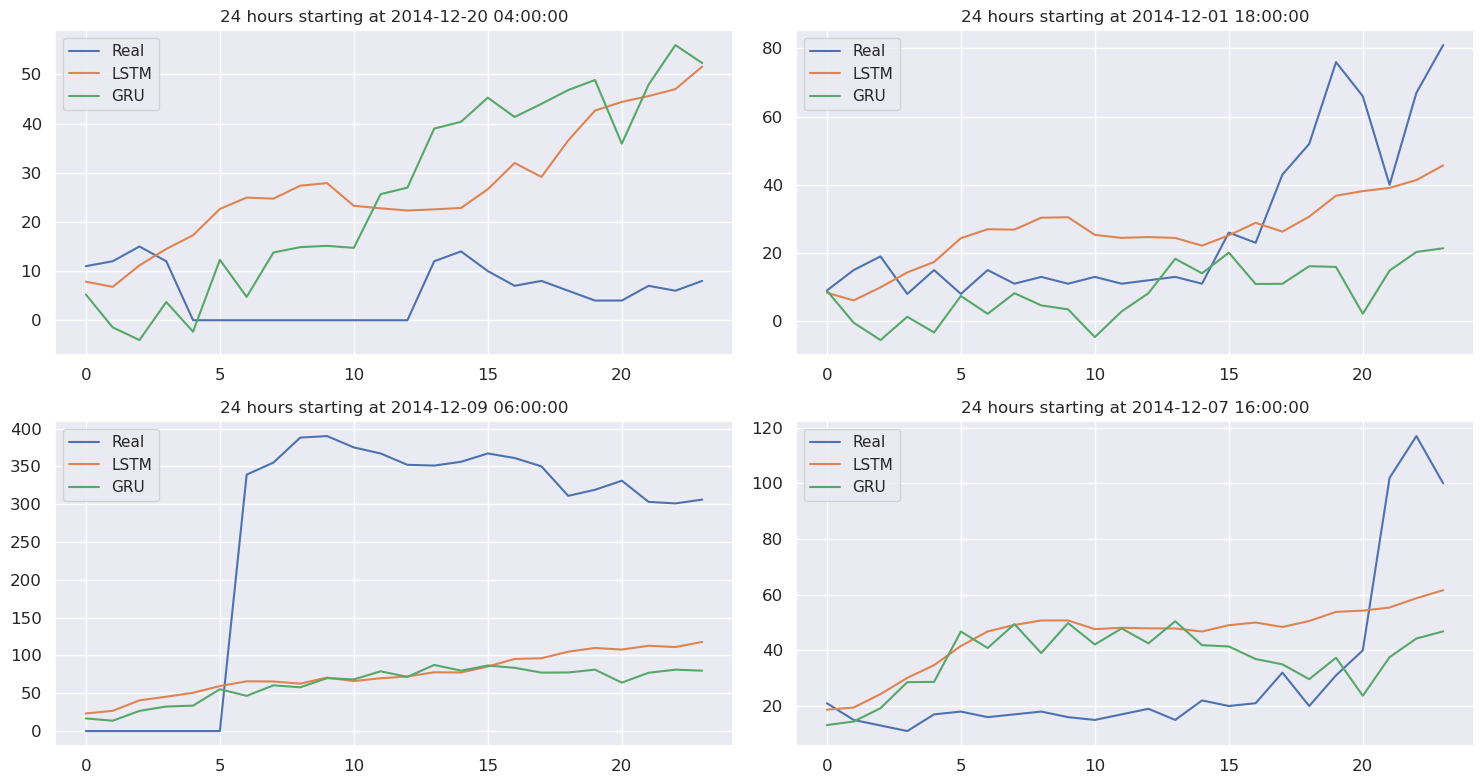

In [53]:
# Visualizing predictions in random intervals
fig, axs = plt.subplots(2, 2, figsize=(15, 8), facecolor='white')
for i, ax in enumerate(axs.flatten()):
    ax.plot(range(24), test_set["pollution"][date_checks[i]:date_checks[i]+24], label="Real")
    ax.plot(range(24), list(get_predictions(best_lstm, lstm_trainer, lstm_loader)[date_checks[i]]), label="LSTM")
    ax.plot(range(24), list(get_predictions(best_gru, gru_trainer, gru_loader)[date_checks[i]]), label="GRU")
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend()
    ax.grid(True)
    ax.title.set_text(f"24 hours starting at {dates[date_checks[i]]}")

plt.legend()
plt.tight_layout()
plt.show()

### Compare models

In [24]:
lstm_metrics = lstm_trainer.test(model=best_lstm, dataloaders=lstm_loader, verbose=False)[0]
gru_metrics = gru_trainer.test(model=best_gru, dataloaders=gru_loader, verbose=False)[0]

lstm_mse_val, lstm_mae_val, lstm_smape_val = lstm_metrics['MSE_test_loss'], lstm_metrics['MAE_test_loss'], lstm_metrics['SMAPE_test_loss']
gru_mse_val, gru_mae_val, gru_smape_val = gru_metrics['MSE_test_loss'], gru_metrics['MAE_test_loss'], gru_metrics['SMAPE_test_loss']

Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

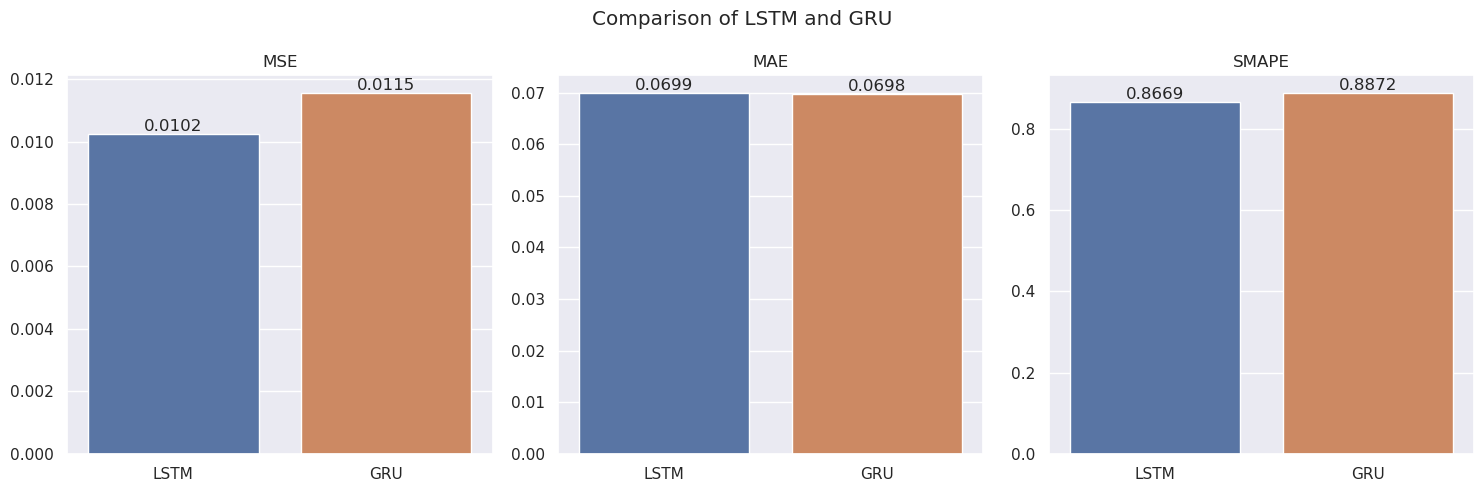

In [25]:
model_names = ["LSTM", "GRU"]
mse_values = [lstm_mse_val, gru_mse_val]
mae_values = [lstm_mae_val, gru_mae_val]
smape_values = [lstm_smape_val, gru_smape_val]

# Create separate subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MSE subplot
mse_bars = sn.barplot(x=model_names, y=mse_values, ax=axes[0])
axes[0].set_title("MSE")

# Annotate
for bar, val in zip(mse_bars.patches, mse_values):
    mse_bars.annotate(f'{round(val, 4)}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

# MAE subplot
mae_bars = sn.barplot(x=model_names, y=mae_values, ax=axes[1])
axes[1].set_title("MAE")

# Annotate
for bar, val in zip(mae_bars.patches, mae_values):
    mae_bars.annotate(f'{round(val, 4)}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

# SMAPE subplot
smape_bars = sn.barplot(x=model_names, y=smape_values, ax=axes[2])
axes[2].set_title("SMAPE")

# Annotate
for bar, val in zip(smape_bars.patches, smape_values):
    smape_bars.annotate(f'{round(val, 4)}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

plt.suptitle("Comparison of LSTM and GRU")
plt.tight_layout()
plt.show()